### Matching month-to-month CPS observations

Updated: August 10, 2020

Brian Dew, @bd_econ


See: https://www.nber.org/papers/t0247

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'

os.chdir('/home/brian/Documents/CPS/data/clean/')

from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)

# Recession start and end months, from NBER
rec_dt = [('1990-07-01', '1991-03-31'), 
          ('2001-03-01', '2001-11-30'), 
          ('2007-12-01', '2009-06-30'),
          ('2020-03-01', '2021-02-01')]

In [2]:
# Identify which months should be matched
start = '1989-02-01'
end = '2021-04-01'
date_list = [(date_val.year, date_val.month) for date_val in 
             pd.date_range(start=start, end=end, freq='MS')]

date_pairs = list(zip(date_list, date_list[1:]))

start_year = date_pairs[0][0][0]

# Keep only the bd CPS columns needed for the analysis
keep_cols = ['CPSID', 'LINENO', 'AGE', 'FEMALE', 'WBHAO', 'BASICWGT',
             'YEAR', 'MONTH', 'LFS']

merge_cols = ['CPSID', 'LINENO', 'WBHAO', 'FEMALE']

def read_year(year):
    df = (pd.read_feather(f'cps{year}.ft', columns=keep_cols)
            .query('BASICWGT > 0 and CPSID > 0'))
    return df

In [3]:
# Match data and calculate flow
results = pd.Series(dtype='float64')

df1 = read_year(start_year)
df2 = df1

# Handle the case where the second match month is the following year
for (year1, month1), (year2, month2) in date_pairs:
    if month2 == 1:
        df2 = read_year(year2)
    if month1 == 1 and year1 > start_year:
        df1 = df2
        
    # Filter annual data to keep only revelant month's data
    d1 = df1.loc[df1['MONTH'] == month1]
    d2 = df2.loc[(df2['MONTH'] == month2) & 
                 (df2['LFS'] == 'Employed')]
    
    # Combine the two months and check that the person matches
    m = pd.merge(d1, d2, on=['CPSID', 'LINENO'], how='inner')
    m = m[(m['WBHAO_x'] == m['WBHAO_y']) &
          (m['FEMALE_x'] == m['FEMALE_y']) &
          (m['AGE_y'] >= m['AGE_x']) &
          (m['AGE_x'] <= m['AGE_y'] + 1)]
    
    # Calculate the newly employed total and share that were NILF
    emp = m.loc[m['LFS_x'] != 'Employed', 'BASICWGT_y'].sum()
    nilf = m.loc[m['LFS_x'] == 'NILF', 'BASICWGT_y'].sum()
    
    # Store results in dataframe
    date = pd.to_datetime(f'{year2}-{month2}-01')
    if emp > 0:
        results[date] = (nilf / emp) * 100
    else:
        results[date] = np.nan
        
sm = x13_arima_analysis(results.loc['1996':])
seas = (results.loc['1996':] - sm.seasadj)
adj = [(i, seas[seas.index.month == i].mean()) for i in range(6, 10)]
oct_val = results.loc['1995-10-01']
results.loc['1995-10-01'] = np.nan
interp = results.loc['1995'].interpolate()
for i, val in adj:
    results.loc[f'1995-0{i}-01'] = interp.loc[f'1995-0{i}-01'] + val
results.loc['1995-10-01'] = oct_val
sm = x13_arima_analysis(results)
resadj = sm.seasadj
resadj.loc['1995-06-01': '1995-09-01'] = np.nan

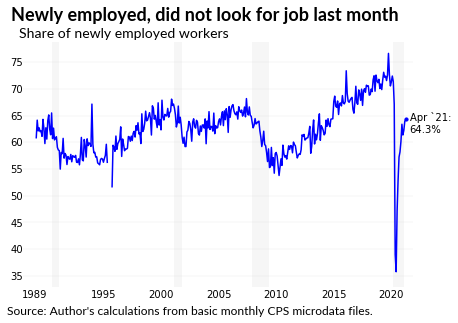

In [4]:
fig, ax = plt.subplots(figsize=(7, 4.5))

resadj.plot(color='blue', zorder=2, ax=ax)
date_text = resadj.index[-1].strftime('%b `%y')
val_text = f'{round(resadj[-1], 1)}%'

# Endpoint dot and label
plt.scatter([resadj.index[-1]], [resadj.iloc[-1]], color='blue', s=10)
plt.text('2021-08-01', resadj.iloc[-1] - 2.4, 
         f'{date_text}:\n{val_text}', ha='left')

plt.xlim('1988-01-01', '2021-12-01')

# Add recession bars
for i, v in rec_dt:
    plt.axvspan(i, v, fill=True, linewidth=0, 
                color='lightgray', alpha=0.2, zorder=1)
    
for yval in range(35, 80, 5):
    ax.hlines(y=yval, xmin='1988-01-01', xmax='2021-12-01', 
              linewidth=0.2, color='lightgray', zorder=0)
    ax.text('1986-12-01', yval-0.6, f'{yval:.0f}')
    
for xval in [1989, 1995, 2000, 2005, 2010, 2015, 2020]:
    ax.text(f'{xval}-01-01', 31, f'{xval}', ha='center')
    
plt.axis('off')

title = 'Newly employed, did not look for job last month'
plt.text(-0.03, 1.09, title,
          fontsize=18, weight='bold', fontname='Lato', 
          transform=ax.transAxes)

plt.text(-0.01, 1.02, "Share of newly employed workers", 
          fontsize=14, fontname='Lato', 
          transform=ax.transAxes)

footer = ("Source: Author's calculations from basic "+
          "monthly CPS microdata files.")

plt.text(-0.04, -0.11, footer, 
          fontsize=12, fontname='Lato', 
          transform=ax.transAxes)

plt.show();